# Домашнее задание «Модели ARMA»
## Задание
 * Выберите ряд из первого задания.
 * Постройте его модель ARIMA.
 
Дополнительное задание
* Попробуйте спрогнозировать график классическим ML.

### импорт библиотек

In [192]:
import warnings
warnings.filterwarnings("ignore")

In [193]:
import pandas as pd
import numpy as np
import tqdm
import sklearn
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

In [194]:
import matplotlib.pyplot as plt
%matplotlib inline

### загрузка данных

In [195]:
!wget https://raw.githubusercontent.com/lteplova/tsml/main/Series/mean-monthly-air-temperature-deg.csv

--2023-06-06 08:45:29--  https://raw.githubusercontent.com/lteplova/tsml/main/Series/mean-monthly-air-temperature-deg.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3615 (3.5K) [text/plain]
Saving to: 'mean-monthly-air-temperature-deg.csv.1'

mean-monthly-air-te 100%[===================>]   3.53K  --.-KB/s    in 0s      

2023-06-06 08:45:29 (12.1 MB/s) - 'mean-monthly-air-temperature-deg.csv.1' saved [3615/3615]



In [196]:
mean_monthly_temp = pd.read_csv("mean-monthly-air-temperature-deg.csv")['Deg']


### вспомогательные функции

In [197]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [198]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


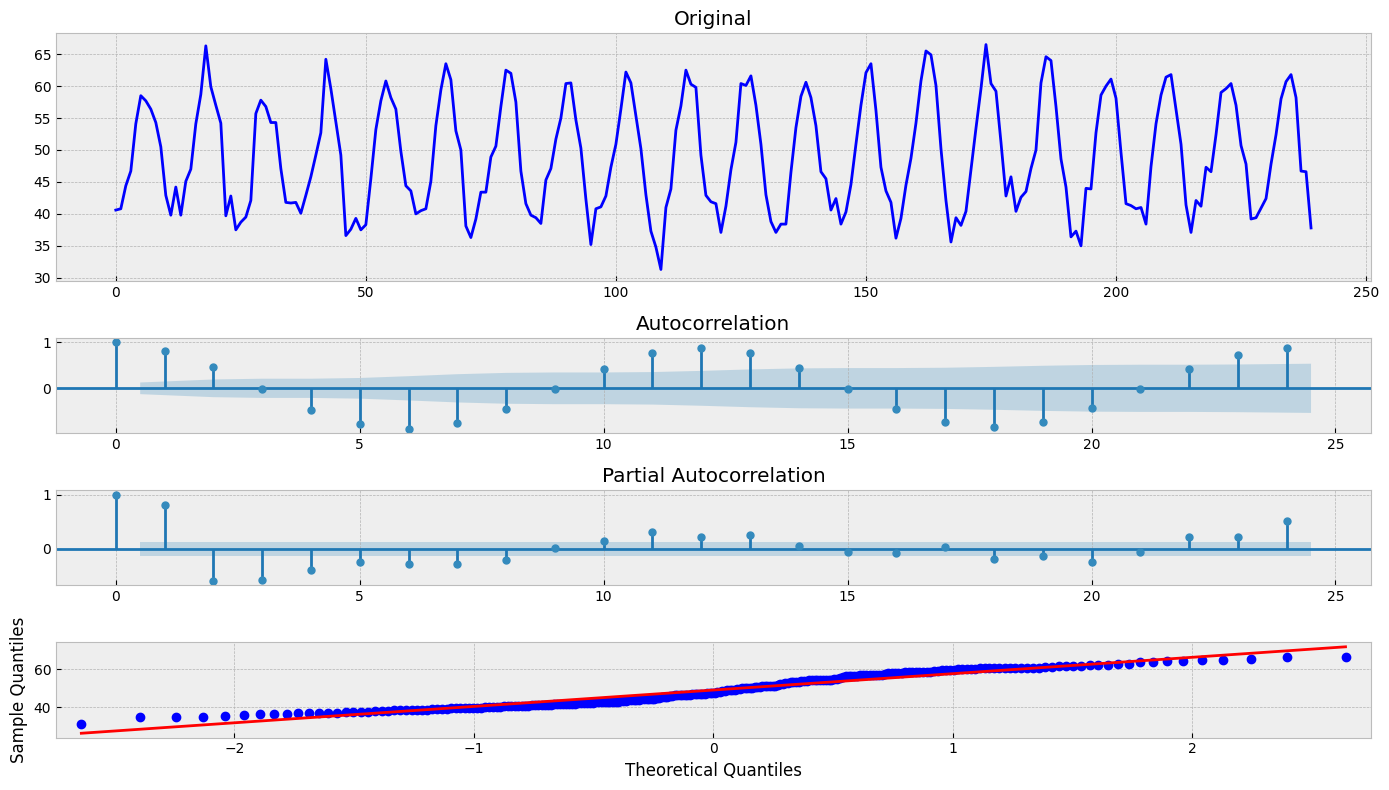

In [199]:
series = mean_monthly_temp
tsplot(series)

In [200]:
# преобразование БоксаКокса
series = boxcox(series, 0)

Results of Dickey-Fuller Test:
Test Statistic                  -3.760996
p-value                          0.003333
#Lags Used                      15.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64


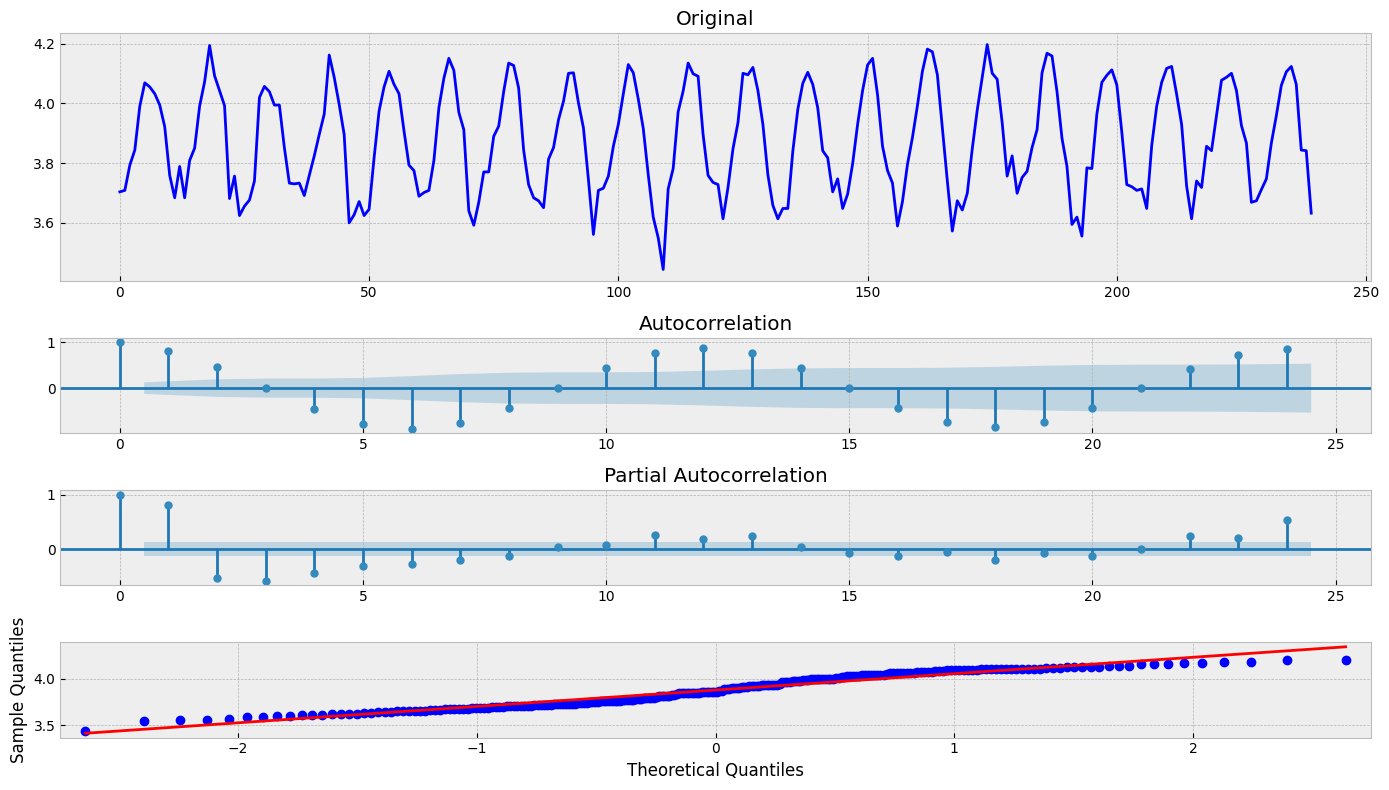

In [201]:
tsplot(series)

Results of Dickey-Fuller Test:
Test Statistic                -6.411725e+00
p-value                        1.883599e-08
#Lags Used                     1.200000e+01
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


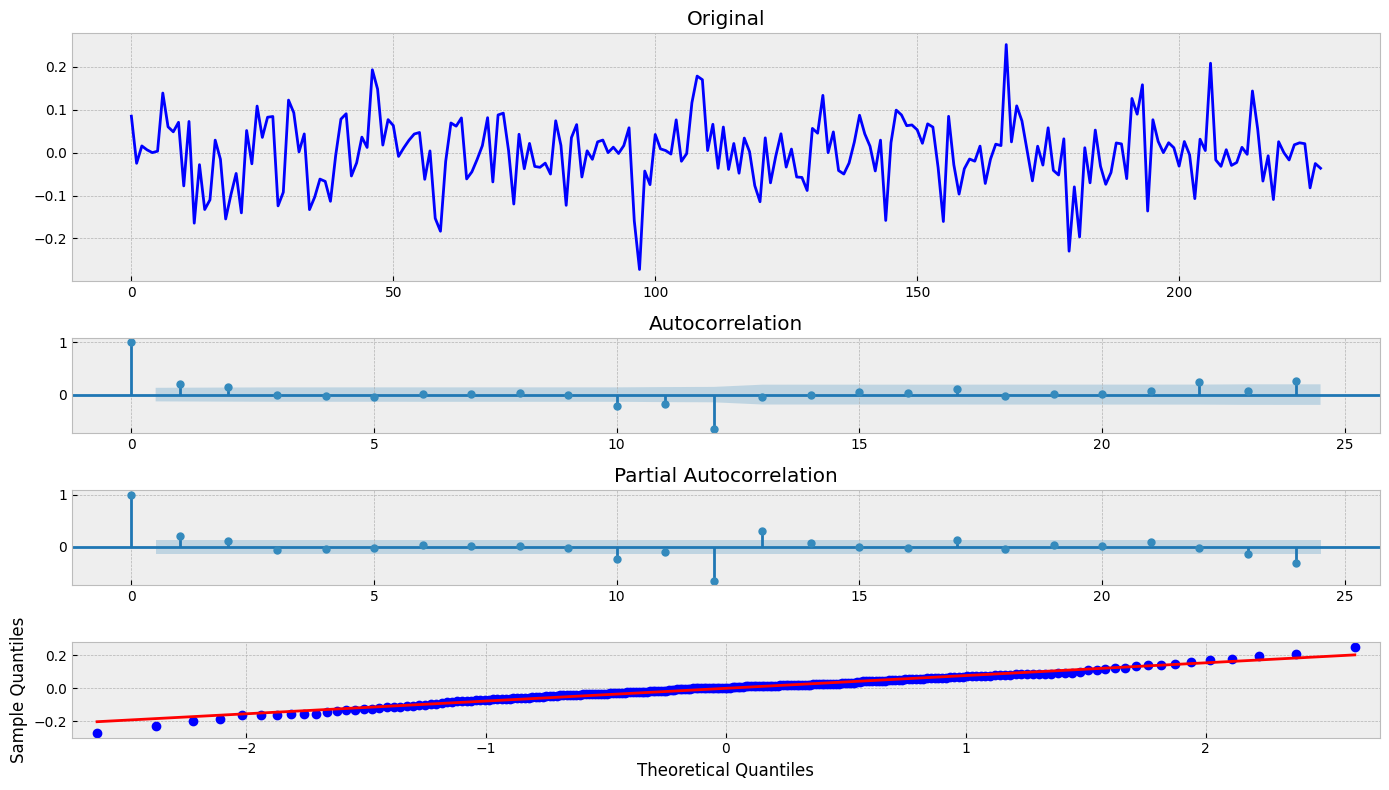

In [202]:
# убираем сезонность
series = series[12:] - series[:-12]
tsplot(series)

In [ ]:
# подбор гиперпараметров
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue

In [204]:
print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: -552.84903 | order: (4, 0, 3)


Results of Dickey-Fuller Test:
Test Statistic                  -5.338423
p-value                          0.000005
#Lags Used                      15.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


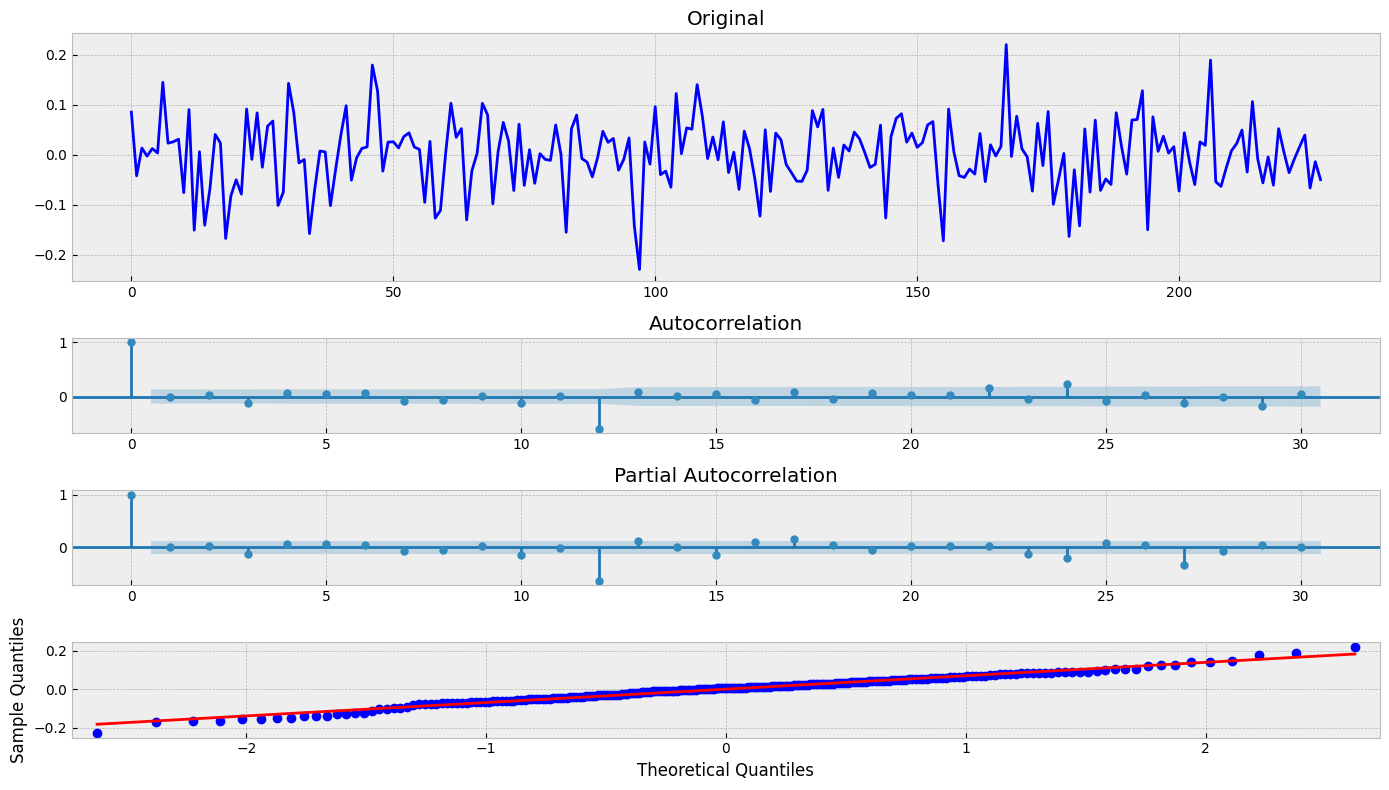

In [205]:
tsplot(best_mdl.resid, lags=30)

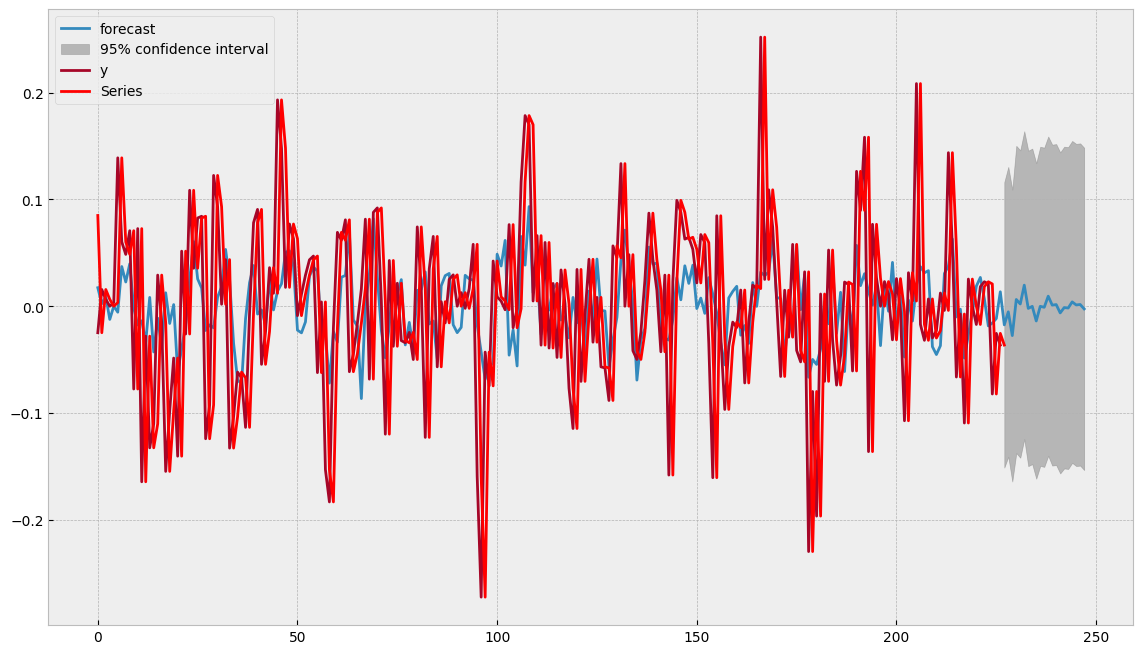

In [206]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(1, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

In [209]:
result_mse_arima = mse(series[:228], best_mdl.predict())

result_mse_arima

0.00484118771774728

In [ ]:
mdl = smt.ARIMA(series, order=(4, 0, 3)).fit(
                method='mle', trend='nc'
            )


Results of Dickey-Fuller Test:
Test Statistic                  -5.338423
p-value                          0.000005
#Lags Used                      15.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


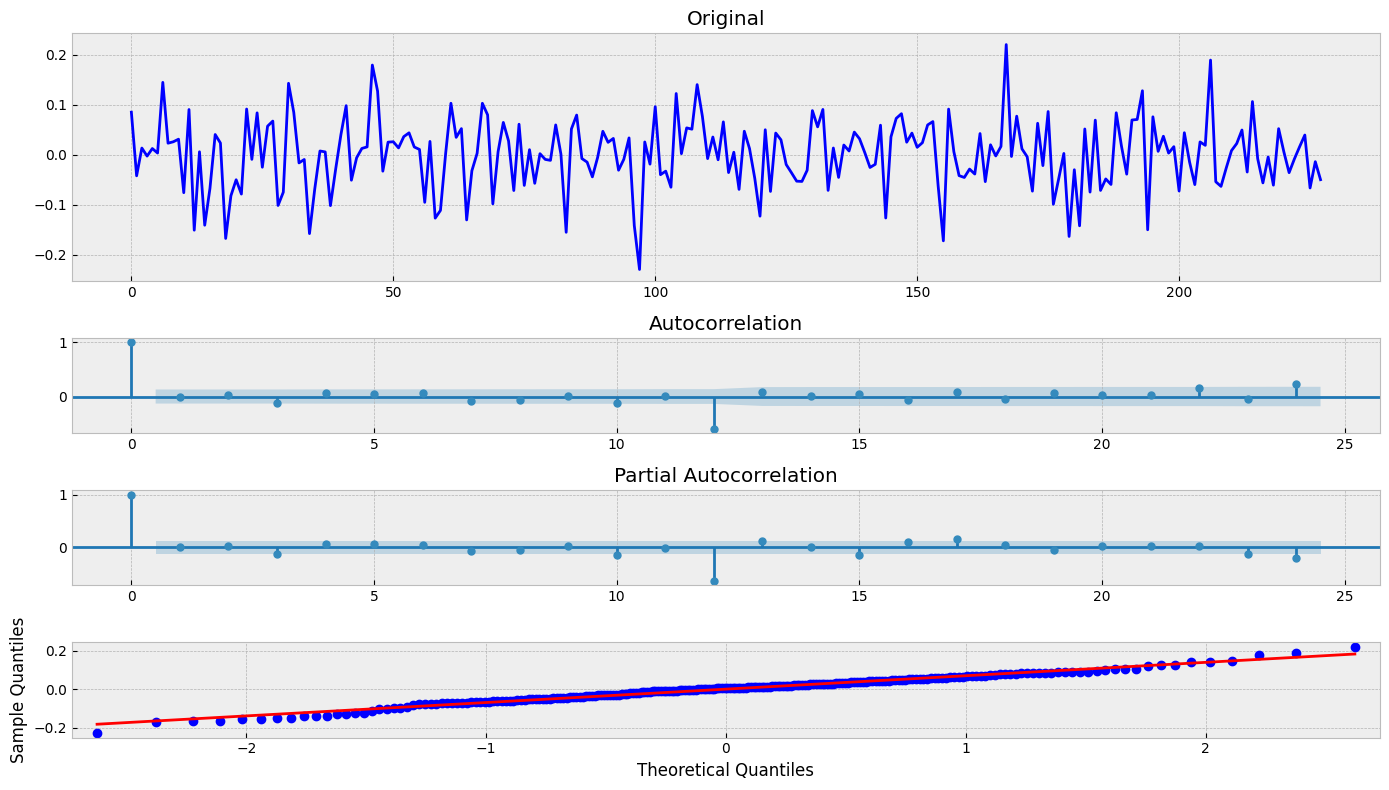

In [219]:
tsplot(mdl.resid)

### Линейная регрессия

In [211]:
series = pd.read_csv("mean-monthly-air-temperature-deg.csv")

In [212]:
series = pd.read_csv("mean-monthly-air-temperature-deg.csv")

def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Deg.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Month"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Deg"], axis=1)
    y_train = data.loc[:test_index]["Deg"]
    X_test = data.loc[test_index:].drop(["Deg"], axis=1)
    y_test = data.loc[test_index:]["Deg"]
    
    return X_train, X_test, y_train, y_test

In [213]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=20, test_size=0.3)

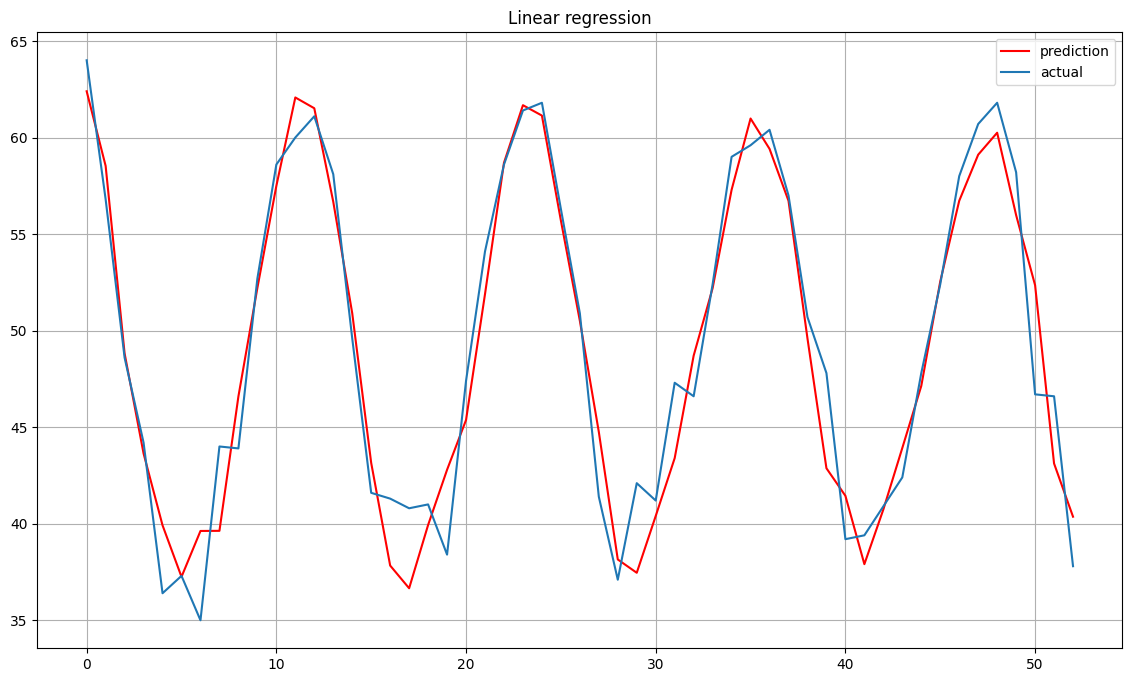

In [214]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

In [216]:
def mse(y_test, prediction):
    y_test, prediction = np.array(y_test), np.array(prediction)
    return np.square(np.subtract(y_test,prediction)).mean()

In [217]:
result_mse = mse(y_test, prediction)

result_mse

5.5770728721695315

In [218]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, prediction)

5.5770728721695315